## Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [18]:
from pathlib import Path

In [19]:
positive_dir = Path('./images/Positive')
negative_dir = Path('./images/Negative')

## Defining Parameters

In [8]:
## image_width
image_width = 120
## image_height
image_height = 120
## image_color_channel_size
image_color_channel_size = 255
## image_size
image_size = (image_width, image_height)
## batch_size
batch_size = 32
## epochs
epochs = 20
## learning_rate
learning_rate = 0.01
## class_names
class_names = ['crack','without_crack']

## Creating DataFrames

In [20]:
def generate_df(image, label):
    filepaths = pd.Series(list(image.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [21]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

df = pd.concat(
    [positive_df, negative_df], axis=0).sample(
    frac=1.0, random_state= 42).reset_index(
    drop=True)
df

,Filepath,Label
0,images/Negative/06881.jpg,NEGATIVE
1,images/Positive/01226.jpg,POSITIVE
2,images/Negative/04640.jpg,NEGATIVE
3,images/Positive/14413_1.jpg,POSITIVE
4,images/Negative/09942.jpg,NEGATIVE
...,...,...
39995,images/Positive/19417.jpg,POSITIVE
39996,images/Positive/10024_1.jpg,POSITIVE
39997,images/Negative/18820.jpg,NEGATIVE
39998,images/Positive/08143.jpg,POSITIVE


In [ ]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report

## Split Data

In [40]:
train_df, test_df = train_test_split(
    df,  # Use the full dataset
    train_size=0.75,
    shuffle=True,
    random_state=42
)

In [41]:
train_df.shape

(30000, 2)

In [42]:
test_df.shape

(10000, 2)

## Loading Image and Rescaling

In [12]:
## validation_split : 
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./image_color_channel_size,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./image_color_channel_size
)

In [43]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

Found 24000 validated image filenames belonging to 2 classes.
Found 6000 validated image filenames belonging to 2 classes.
Found 10000 validated image filenames belonging to 2 classes.


## Training Model

In [44]:
inputs = tf.keras.Input(shape=(120,120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [45]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [46]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 59, 59, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_1  (None, 32)                0   

In [47]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)

Epoch 1/20
750/750 [==============================] - 34s 45ms/step - loss: 0.3400 - accuracy: 0.8553 - val_loss: 0.1093 - val_accuracy: 0.9702
Epoch 2/20
750/750 [==============================] - 33s 44ms/step - loss: 0.1329 - accuracy: 0.9621 - val_loss: 0.0813 - val_accuracy: 0.9792
Epoch 3/20
750/750 [==============================] - 33s 44ms/step - loss: 0.1029 - accuracy: 0.9701 - val_loss: 0.0752 - val_accuracy: 0.9807
Epoch 4/20
750/750 [==============================] - 33s 44ms/step - loss: 0.1026 - accuracy: 0.9709 - val_loss: 0.0753 - val_accuracy: 0.9808
Epoch 5/20
750/750 [==============================] - 33s 45ms/step - loss: 0.0940 - accuracy: 0.9713 - val_loss: 0.0775 - val_accuracy: 0.9775
Epoch 6/20
750/750 [==============================] - 58s 78ms/step - loss: 0.0949 - accuracy: 0.9723 - val_loss: 0.0749 - val_accuracy: 0.9797
Epoch 7/20
750/750 [==============================] - 33s 44ms/step - loss: 0.0956 - accuracy: 0.9709 - val_loss: 0.0741 - val_accuracy:

## Results and Predictions

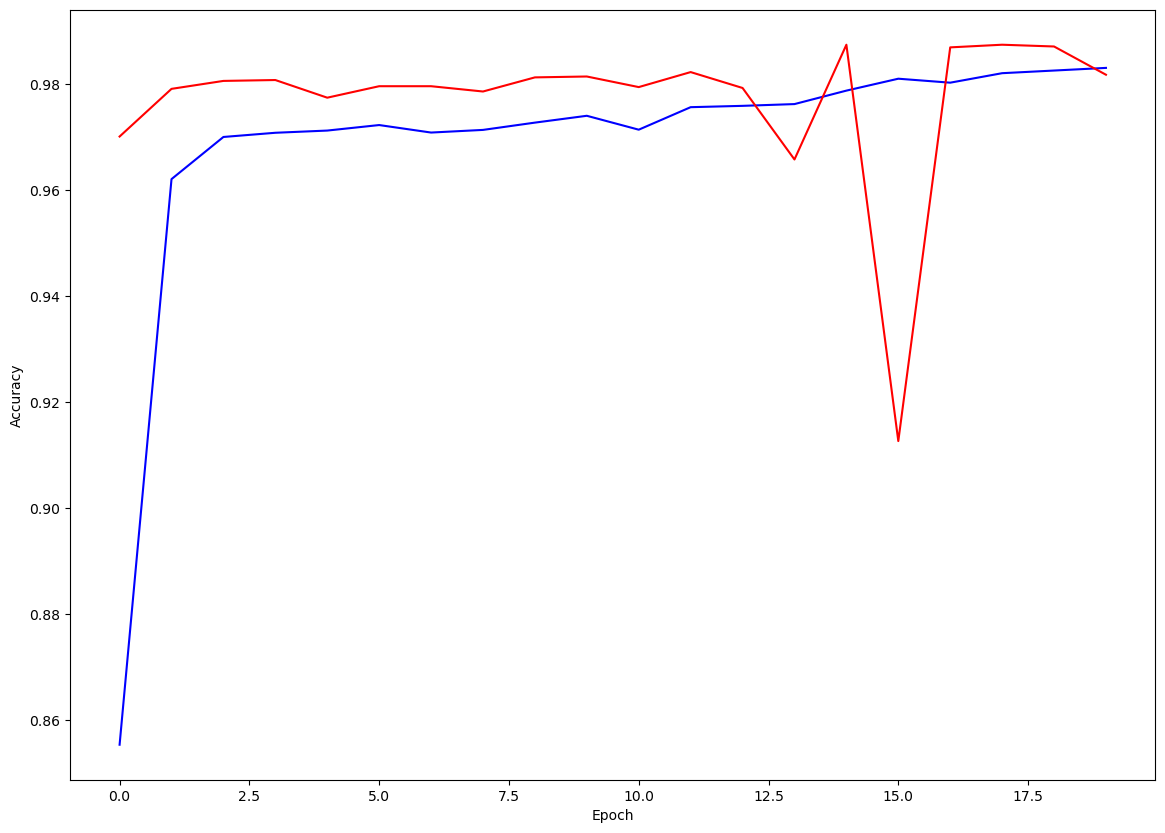

In [48]:
plt.figure(figsize=(14, 10))

plt.plot(range(epochs), history.history['accuracy'], color='b')
plt.plot(range(epochs), history.history['val_accuracy'], color='r')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

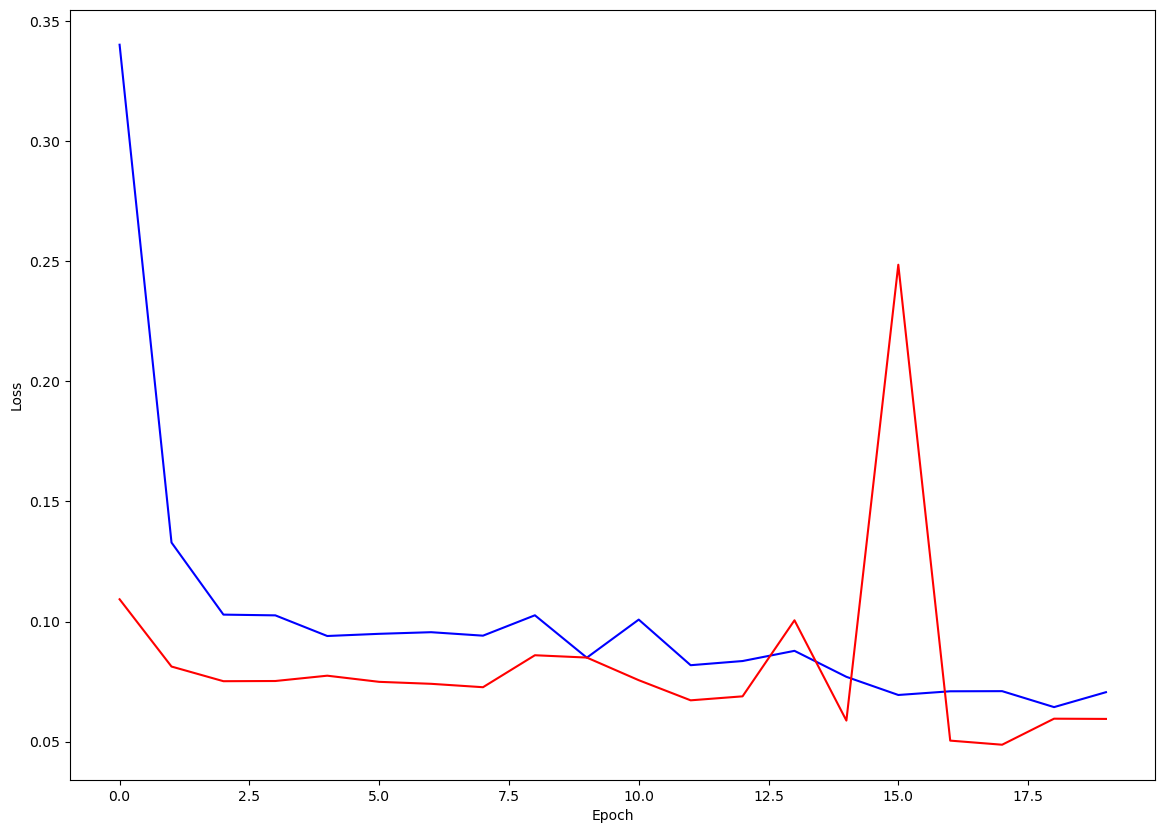

In [49]:
plt.figure(figsize=(14, 10))

plt.plot(range(epochs), history.history['loss'], color='b')
plt.plot(range(epochs), history.history['val_loss'], color='r')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [50]:
results = model.evaluate(test_data)
loss = results[0]
acc = results[1]

print('Accuracy of the model: {:0.2f}%' .format(acc*100))
print('Loss of the model: {:0.2f}' .format(loss))

313/313 [==============================] - 6s 20ms/step - loss: 0.0664 - accuracy: 0.9791
Accuracy of the model: 97.91%
Loss of the model: 0.07


313/313 [==============================] - 6s 19ms/step


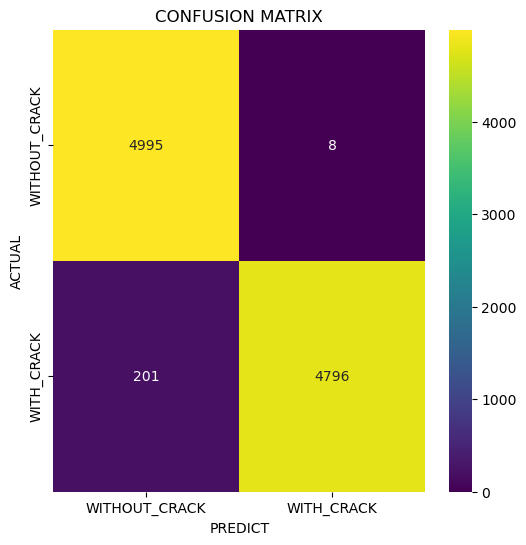

ClASSIFICATION REPORT:
----------------------
               precision    recall  f1-score   support

WITHOU_CRACK       0.96      1.00      0.98      5003
  WITH_CRACK       1.00      0.96      0.98      4997

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [51]:
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int_))
cm = confusion_matrix(test_data.labels, y_pred)
clr = classification_report(test_data.labels, y_pred, target_names=["WITHOU_CRACK", "WITH_CRACK"])
    
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True,fmt= 'g', vmin=0, cmap='viridis')
plt.xticks(ticks=np.arange(2) + 0.5, labels=["WITHOUT_CRACK", "WITH_CRACK"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["WITHOUT_CRACK", "WITH_CRACK"])
plt.xlabel("PREDICT")
plt.ylabel("ACTUAL")
plt.title("CONFUSION MATRIX")
plt.show()
print("ClASSIFICATION REPORT:\n----------------------\n", clr)

In [52]:
sample_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)
sample_images = sample_generator.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

Found 10000 validated image filenames belonging to 2 classes.


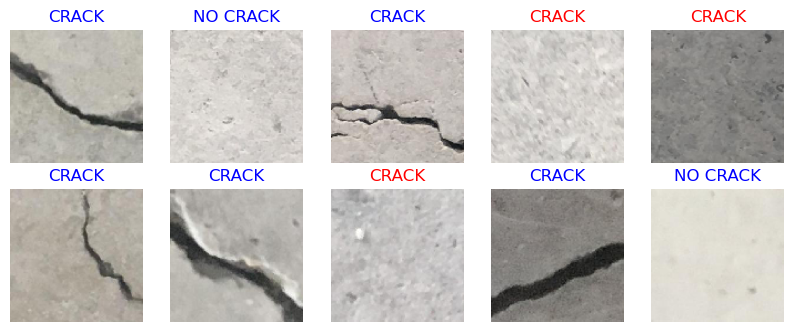

In [56]:
samples = sample_images.next()
labels = samples[1].astype(np.int_)

plt.figure(figsize=(10,10))

for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.imshow(samples[0][i])
    plt.axis('off')
    plt.title(("CRACK" if y_pred[i] == 1 else "NO CRACK"), color=("blue" if labels[i] == y_pred[i] else "red"))